In [1]:
import numpy as np
import pickle as pkl
import glob
import torch
import matplotlib.pyplot as plt

import bvcopula

In [2]:
path = './out/'
animal = 'ST263'
dayN = 4
day_name = 'Day{}'.format(dayN)
exp_pref = '{}_{}'.format(animal,day_name)
print(glob.glob(path+exp_pref+"*.pkl"))

['./out/ST263_Day4_8108_models.pkl', './out/ST263_Day4_9704_models.pkl', './out/ST263_Day4_2163_models.pkl']


In [3]:
with open('./out/ST263_Day4_9704_models.pkl','rb') as f:
    new_data = pkl.load(f)

In [4]:
data = np.empty((28,28),dtype=object)
with open('./out/ST263_Day4_2163_models.pkl','rb') as f:
    new_data = pkl.load(f)
for i in range(-5,5):
    for j in range(i+1,23):
        if new_data[i,j]!=None:
            assert data[i+5,j+5]==None
            data[i+5,j+5] = new_data[i,j]
with open('./out/ST263_Day4_9704_models.pkl','rb') as f:
    new_data = pkl.load(f)
for i in range(4,8):
    for j in range(i+1,23):
        if (new_data[i,j]!=None) & ((i<7) | (j<15)):
            assert (data[i+5,j+5]==None)
            data[i+5,j+5] = new_data[i,j]
with open('./out/ST263_Day4_8108_models.pkl','rb') as f:
    new_data = pkl.load(f)
for i in range(0,22):
    for j in range(i+1,23):
        if new_data[i,j]!=None:
            assert data[i+5,j+5]==None
            data[i+5,j+5] = new_data[i,j]

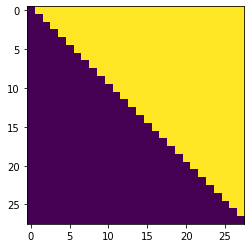

In [5]:
plt.imshow((data!=None)*1.0)

In [6]:
#parse text results

def neuron_ids(string):
    arr = str.split(string,sep='-')
    n1,n2 = 1,1
    which = 0
    for a in arr:
        try:
            n = int(a)
            if which:
                n2*=n
            else:
                n1*=n
                which=1
        except ValueError:
            if which:
                n2 = -1
            else:
                n1 = -1
    return n1,n2

import csv

NN = 23
beh = 5
data = np.empty((NN+beh,NN+beh),dtype=object)

with open(path+'ST263_Day4_model_list.txt','r') as f:
    next(f) # skip headings
    reader=csv.reader(f,delimiter='\t')
    for res,waic,time in reader:
        neuron, copula = str.split(res)
        n1,n2 = neuron_ids(neuron)
        data[n1+beh,n2+beh] = [copula,waic,time,n1,n2]

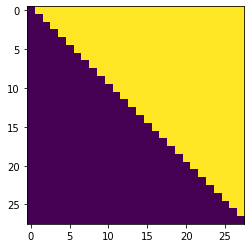

In [7]:
plt.imshow((data!=None)*1.0)

In [8]:
copulas = {}
for d in data.reshape(-1):
    if d is not None:
        try:
            copulas[d[0]] += 1
        except KeyError:
            copulas[d[0]] = 1

In [9]:
[copulas['Independence'],copulas['Gaussian'],copulas['Frank']]

[309, 16, 13]

In [10]:
import re

copula_names = ['Independence','Gaussian','Frank','Clayton','Gumbel']
new_dict = {}

for key, value in copulas.items():
    binary_key = np.zeros(len(copula_names)).astype(int) #4 types of copulas
    for i, name in enumerate(copula_names):
        if re.search(name,key):
            binary_key[i]+=1
    new_key = ''.join([str(b) for b in binary_key])
    try:
        new_dict[new_key] += value
    except KeyError:
        new_dict[new_key] = value

In [11]:
new_dict

{'00100': 13,
 '00110': 3,
 '10000': 309,
 '01000': 16,
 '10100': 7,
 '01010': 14,
 '11001': 2,
 '01100': 7,
 '10010': 1,
 '01110': 1,
 '00101': 1,
 '01001': 1,
 '10110': 1,
 '11000': 1,
 '10101': 1}

In [12]:
copulas

{'Frank': 13,
 'FrankClayton270°': 1,
 'Independence': 309,
 'Clayton270°Frank': 1,
 'Gaussian': 16,
 'IndependenceFrank': 7,
 'Clayton90°Gaussian': 4,
 'IndependenceGumbel90°Gaussian': 1,
 'Clayton0°Gaussian': 2,
 'Clayton180°Gaussian': 5,
 'FrankGaussian': 6,
 'GaussianClayton180°': 1,
 'FrankClayton180°': 1,
 'IndependenceClayton180°': 1,
 'FrankClayton180°Gaussian': 1,
 'FrankGumbel0°': 1,
 'GaussianGumbel0°': 1,
 'GaussianFrank': 1,
 'Clayton180°IndependenceFrank': 1,
 'IndependenceGaussian': 1,
 'FrankIndependenceGumbel0°': 1,
 'Clayton270°Gaussian': 2,
 'IndependenceGumbel0°Gaussian': 1}

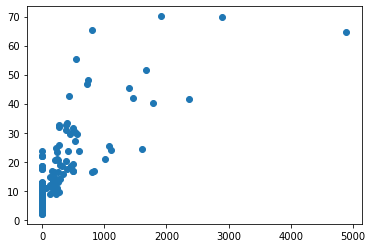

In [13]:
x, y = [], []
n1, n2 = [], []
for d in data.reshape(-1):
    if d is not None:
        x.append(int(d[1]))
        y.append(int(d[2])/60)
        n1.append(int(d[3]))
        n2.append(int(d[4]))
plt.scatter(x,y)

In [14]:
for n1 in range(-5,-3):
    for n2 in range(n1+1,NN):
        pass
       # print(data[n1+beh,n2+beh])

In [16]:
def _get_copula(likelihood, f, sample_size): #likelihood method
    thetas, mixes = likelihood.gplink_function(f)
    thetas = thetas.expand(sample_size+thetas.shape)
    mixes = mixes.expand(sample_size+mixes.shape)
    print(thetas.shape)
    thetas = torch.einsum('ijkl->jkli', thetas) # now: [copulas, positions, samples]
    mixes = torch.einsum('ijkl->jkli', mixes)
    copulas = [lik.copula for lik in likelihood.likelihoods]
    rotations = [lik.rotation for lik in likelihood.likelihoods]
    return likelihood.copula(thetas,mixes,copulas,rotations=rotations)
    
def _entropy_given_params(copula, alpha=0.05, sem_tol=1e-3): #copula_method
        # Gaussian confidence interval for sem_tol and level alpha
        conf = torch.erfinv(torch.tensor([1. - alpha]))
        sem = torch.ones(copula.theta.shape[1])*float('inf')
        ent = torch.zeros(copula.theta.shape[1])
        var_sum = torch.zeros(copula.theta.shape[1])
        log2 = torch.tensor([2.]).log()
        k = 0
        mc_size = copula.theta.shape[-1]
        with torch.no_grad():
            while torch.all(sem >= sem_tol):
                # Generate samples
                samples = copula.rsample()
                logp = copula.log_prob(samples)
                assert torch.all(logp==logp)
                logp = logp.mean(dim=(-1,-2)) # collapse sample and conditional dimensions
                log2p = logp[logp.abs()!=float("inf")] / log2 #maybe should check for inf 2 lines earlier
                k += 1
                # Monte-Carlo estimate of entropy
                ent += (-log2p - ent) / k
                # Estimate standard error
                var_sum += ((-log2p - ent) ** 2).sum()
                print(var_sum)
                sem = conf * (var_sum / (k * mc_size * (k * mc_size - 1))).pow(.5)
        return ent, sem
    
def measure_MI(n1,n2,likelihoods,device,cond_mc_size=10,samp_mc_size=100000):
    get_weights_filename = glob.glob('{}{}/model__cuda:?_{}-{}.pth'.format(path,exp_pref,n1,n2))
    if len(get_weights_filename)>0:
        if len(get_weights_filename)>1:
            print('There is more then 1 file, taking the first one')
        interv=torch.tensor([0.,1.])
        points = torch.empty(size=torch.Size([cond_mc_size])).to(device=device)
        points = points.uniform_(*interv)
        model = bvcopula.load_model(get_weights_filename[0], likelihoods, device)
        with torch.no_grad():
            fs = model(points).rsample(torch.Size([10]))
        copula = _get_copula(model.likelihood, fs, sample_size = torch.Size([samp_mc_size]))
        MI, sem = _entropy_given_params(copula)
        print(sem)
#         MIs = []
#         for f in fs:
#             copula = _get_copula(model.likelihood, f, sample_size = torch.Size([samp_mc_size]))
#             MI, _ = _entropy_given_params(copula)
#             MIs.append(MI)
        print(MI.mean(),MI.std())
    else:
        print('Weights file not found.')
%time measure_MI(-5, -4, [bvcopula.FrankCopula_Likelihood()], torch.device('cpu'))

torch.Size([100000, 1, 10, 10])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor(-0.0637) tensor(0.0025)
CPU times: user 15.4 s, sys: 2.52 s, total: 17.9 s
Wall time: 6.12 s


In [18]:
model.likelihood

NameError: name 'model' is not defined

In [17]:
_get_copula(model.likelihood, f, sample_size = torch.Size([mc_size]))

NameError: name 'model' is not defined

In [19]:
import bvcopula

def measure_MI(n1,n2,likelihoods,device):
    get_weights_filename = glob.glob('{}{}/model__cuda:?_{}-{}.pth'.format(path,exp_pref,n1,n2))
    if len(get_weights_filename)>0:
        if len(get_weights_filename)>1:
            print('There is more then 1 file, taking the first one')
        model = bvcopula.load_model(get_weights_filename[0], likelihoods, device)
        MI, dMI = [-el.cpu().item() for el in model.entropy(sem_tol=1e-3)] #FIX ME
        print(MI)
    else:
        print('Weights file not found.')
measure_MI(-5, -4, [bvcopula.FrankCopula_Likelihood()], torch.device('cuda:0'))

0.06334679573774338
